In [1]:
# Part four - Visualize the graph
# 2.2MB in size still

# this copy only shows the graph from the smaller portion of the entire NYC dataset


In [2]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import requests
from bs4 import BeautifulSoup
import urllib2
import re
from xml.sax.saxutils import escape
from HTMLParser import HTMLParser
import numpy as np
from multiprocessing import Pool
import networkx as nx
import pickle
import dill
import time
import itertools
from itertools import chain
import csv
#import nltk
#from nltk.tag import pos_tag
import matplotlib.pyplot as plt
import graph_tool.all as gt

In [3]:
# a function to take a networkx graph...and make it into a graph_tool graph!

def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, unicode):
        # Encode the key as ASCII
        key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, unicode):
        tname = 'string'
        value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes_iter(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges_iter(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes_iter(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges_iter(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG


if __name__ == '__main__':

    # Create the networkx graph
    nxG = nx.Graph(name="Undirected Graph")
    nxG.add_node("v1", name="alpha", color="red")
    nxG.add_node("v2", name="bravo", color="blue")
    nxG.add_node("v3", name="charlie", color="blue")
    nxG.add_node("v4", name="hub", color="purple")
    nxG.add_node("v5", name="delta", color="red")
    nxG.add_node("v6", name="echo", color="red")

    nxG.add_edge("v1", "v2", weight=0.5, label="follows")
    nxG.add_edge("v1", "v3", weight=0.25, label="follows")
    nxG.add_edge("v2", "v4", weight=0.05, label="follows")
    nxG.add_edge("v3", "v4", weight=0.35, label="follows")
    nxG.add_edge("v5", "v4", weight=0.65, label="follows")
    nxG.add_edge("v6", "v4", weight=0.53, label="follows")
    nxG.add_edge("v5", "v6", weight=0.21, label="follows")

    for item in nxG.edges_iter(data=True):
        print item

# from http://bbengfort.github.io/snippets/2016/06/23/graph-tool-from-networkx.html


('v1', 'v2', {'weight': 0.5, 'label': 'follows'})
('v1', 'v3', {'weight': 0.25, 'label': 'follows'})
('v2', 'v4', {'weight': 0.05, 'label': 'follows'})
('v3', 'v4', {'weight': 0.35, 'label': 'follows'})
('v4', 'v5', {'weight': 0.65, 'label': 'follows'})
('v4', 'v6', {'weight': 0.53, 'label': 'follows'})
('v5', 'v6', {'weight': 0.21, 'label': 'follows'})


In [4]:
# make smaller graphs
def trim_nodes(G,d):
    """ returns a copy of G without 
    the nodes with a degree less than d """
    Gt = G.copy()
    dn = nx.degree(Gt)
    for n in Gt.nodes():
        if dn[n] <= d:
            Gt.remove_node(n)
    return Gt

def select_nodes(G,d):
    """ returns a copy of G without 
    the nodes with a degree more than d """
    Gt = G.copy()
    dn = nx.degree(Gt)
    for n in Gt.nodes():
        if dn[n] >= d:
            Gt.remove_node(n)
    return Gt

In [5]:
# read in a graph - we have a number of choices as we saved as
# nx.write_gml(Gee, "Gee_full.gml.gz")
# nx.write_graphml(Gee, "Gee.graphml")
G1 = nx.read_graphml("Gee_small.graphml")
# also see later for Gephi results 
# nx.write_gexf(Gee,'Gee.gexf') # 20MB file

In [6]:
# using graph tool
Gt = trim_nodes(G1,5) # trim for speed
gtG = nx2gt(Gt)
gtG.list_properties()


edge_default   (graph)   (type: python::object, val: {})
node_default   (graph)   (type: python::object, val: {})
id             (vertex)  (type: string)
weight         (edge)    (type: double)


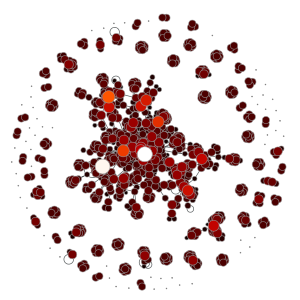

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fbed324f610, at 0x7fbf30e68090>

In [34]:
#g = gt.collection.data["polblogs"]
#g = gt.GraphView(g, vfilt=gt.label_largest_component(g))
pr = gt.pagerank(gtG)
gt.graph_draw(gtG, vertex_fill_color=pr,output_size=(300,300),
               vertex_size=gt.prop_to_size(pr, mi=1, ma=15),
               vorder=pr, vcmap=matplotlib.cm.gist_heat,
               output="G1_pagerank_small.pdf")

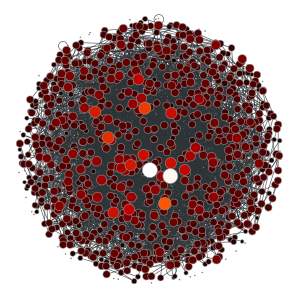

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fbed324f610, at 0x7fbee004b090>

In [35]:
#ret = gt.random_rewire(g, "correlated")

# pos = gt.arf_layout(gtG) # fails
# try this
pos = gt.arf_layout(gtG, max_iter=100, dt=1e-4) # 80 seconds on 8cpu laptop
#g = gt.collection.data["polblogs"]
#g = gt.GraphView(g, vfilt=gt.label_largest_component(g))
pr = gt.pagerank(gtG)
gt.graph_draw(gtG, pos=pos, vertex_fill_color=pr,output_size=(300,300),
               vertex_size=gt.prop_to_size(pr, mi=1, ma=15),
               vorder=pr, vcmap=matplotlib.cm.gist_heat,
               output="G1_pagerank_arf_layout_small.pdf")

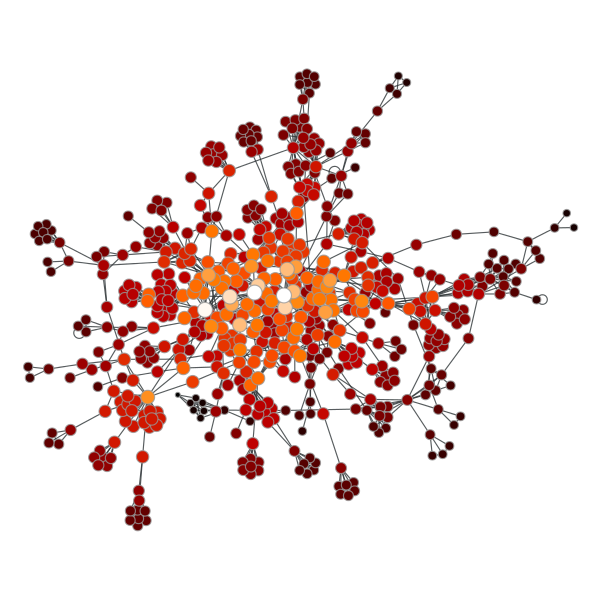

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9003c16890, at 0x7f906965d5d0>

In [13]:
#g = gt.collection.data["polblogs"]
#pos = gt.arf_layout(gtG)
gtG = gt.GraphView(gtG, vfilt=gt.label_largest_component(gtG))
c = gt.closeness(gtG)
gt.graph_draw(gtG, vertex_fill_color=c,
               vertex_size=gt.prop_to_size(c, mi=5, ma=15),
               vcmap=matplotlib.cm.gist_heat,
               vorder=c, output="MY_TEST_polblogs_closeness_graphview.pdf")

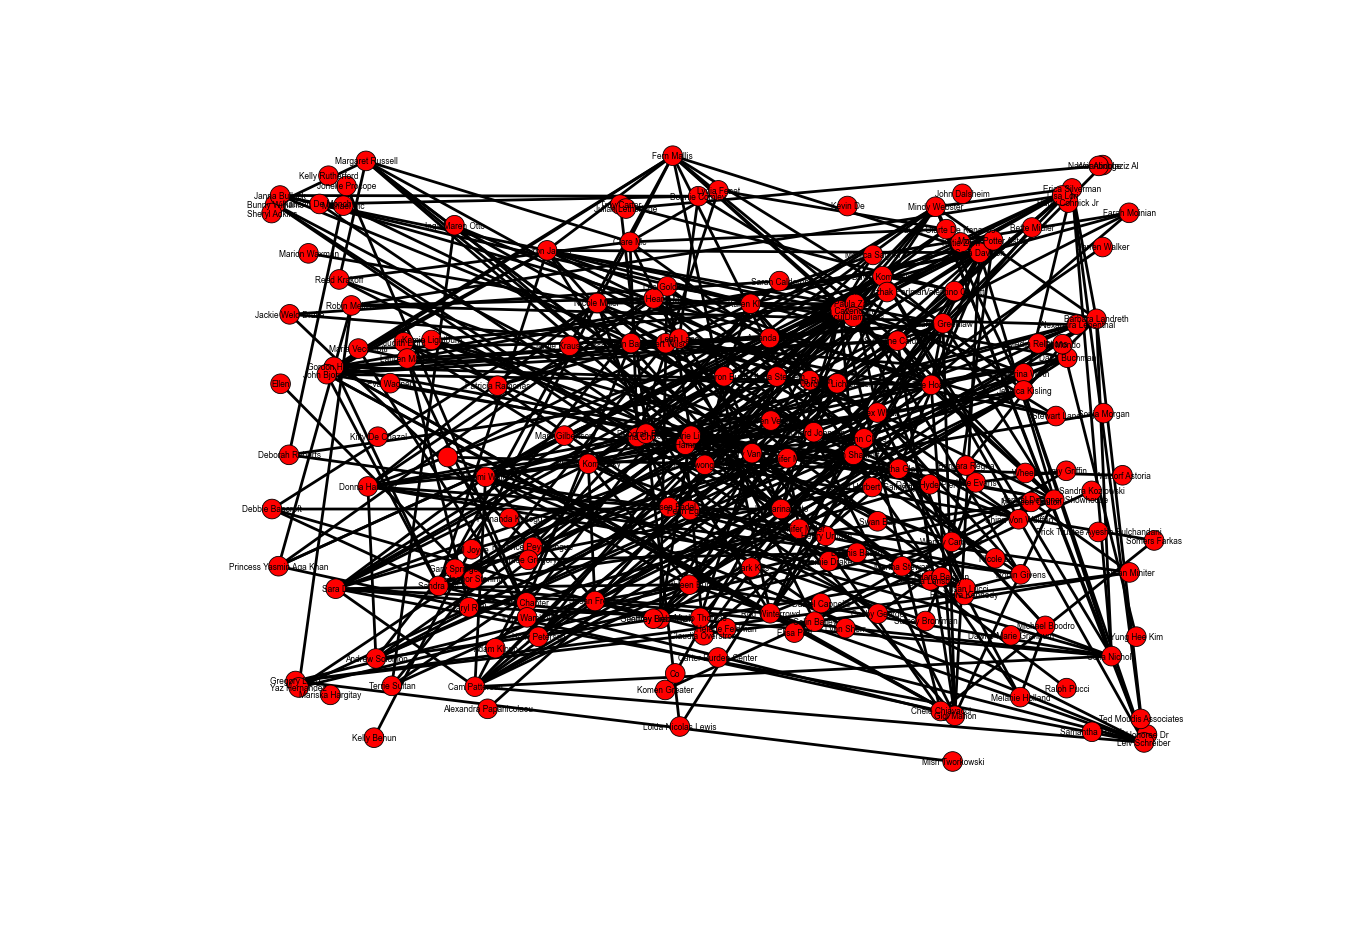

In [42]:
Gt = trim_nodes(G1,10)
elarge=[(u,v) for (u,v,d) in Gt.edges(data=True) if d['weight'] >0.5]
esmall=[(u,v) for (u,v,d) in Gt.edges(data=True) if d['weight'] <=0.5]

#pos=nx.spring_layout(Gt) # positions for all nodes
pos=nx.random_layout(Gt) # positions for all nodes
#pos=nx.circular_layout(Gt) # positions for all nodes
#pos=nx.spectral_layout(Gt) # positions for all nodes

# nodes
nx.draw_networkx_nodes(Gt,pos,node_size=50)

# edges
nx.draw_networkx_edges(Gt,pos,edgelist=elarge,
                    width=1)
nx.draw_networkx_edges(Gt,pos,edgelist=esmall,
                    width=1,alpha=0.5)#,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(Gt,pos,font_size=3,font_family='sans-serif')

plt.axis('off')
plt.savefig("3weighted_graph.png") # save as png
plt.show() # display

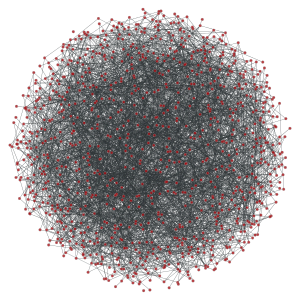

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fbed324f610, at 0x7fbed324f210>

In [44]:
#g = gt.price_network(300)
#pos = gt.arf_layout(gtG, max_iter=0) # should this be zero for me?
pos = gt.arf_layout(gtG, max_iter=100, dt=1e-4) # 80 seconds on 8cpu laptop

gt.graph_draw(gtG, pos=pos,output_size=(300,300), output="SOCIAL_graph-draw-arf.pdf") # takes really long strange...

In [24]:
#g = gt.price_network(1000)
#pos = gt.radial_tree_layout(g, g.vertex(0))
#gt.graph_draw(g, pos=pos, output="graph-draw-radial.pdf")

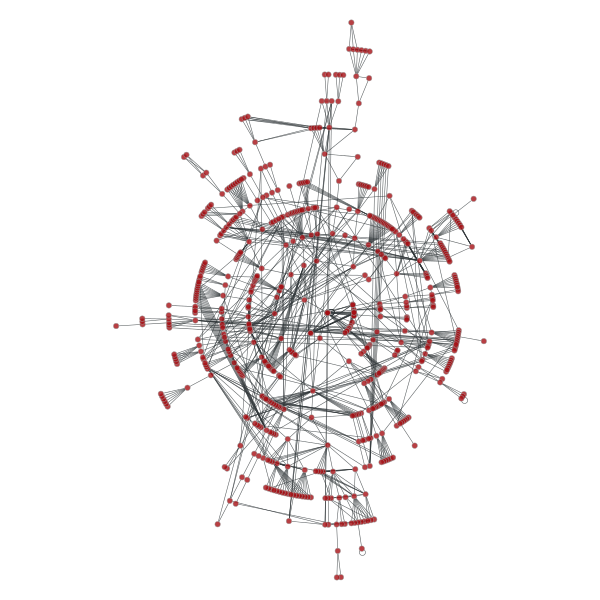

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f90100ee890, at 0x7f90037bdd90>

In [8]:
pos = gt.radial_tree_layout(gtG, gtG.vertex(0))
gt.graph_draw(gtG, pos=pos, output="SOCIAL_graph-draw-radial.pdf")

In [25]:
#g = gt.lattice([10, 10])
#pos = gt.planar_layout(g)
#gt.graph_draw(g, pos=pos, output="lattice-planar.pdf")

In [45]:
#g = gt.price_network(1500)
#deg = g.degree_property_map("in")
#deg.a = 4 * (sqrt(deg.a) * 0.5 + 0.4)
#ebet = gt.betweenness(g)[1]
#ebet.a /= ebet.a.max() / 10.
#eorder = ebet.copy()
#eorder.a *= -1
#pos = gt.sfdp_layout(g)
#control = g.new_edge_property("vector<double>")
#for e in g.edges():
#    d = sqrt(sum((pos[e.source()].a - pos[e.target()].a) ** 2)) / 5
#    control[e] = [0.3, d, 0.7, d]
#gt.graph_draw(g, pos=pos, vertex_size=deg, vertex_fill_color=deg, vorder=deg,
#              edge_color=ebet, eorder=eorder, edge_pen_width=ebet,
#              edge_control_points=control, # some curvy edges
#              output="XXgraph-draw.pdf")

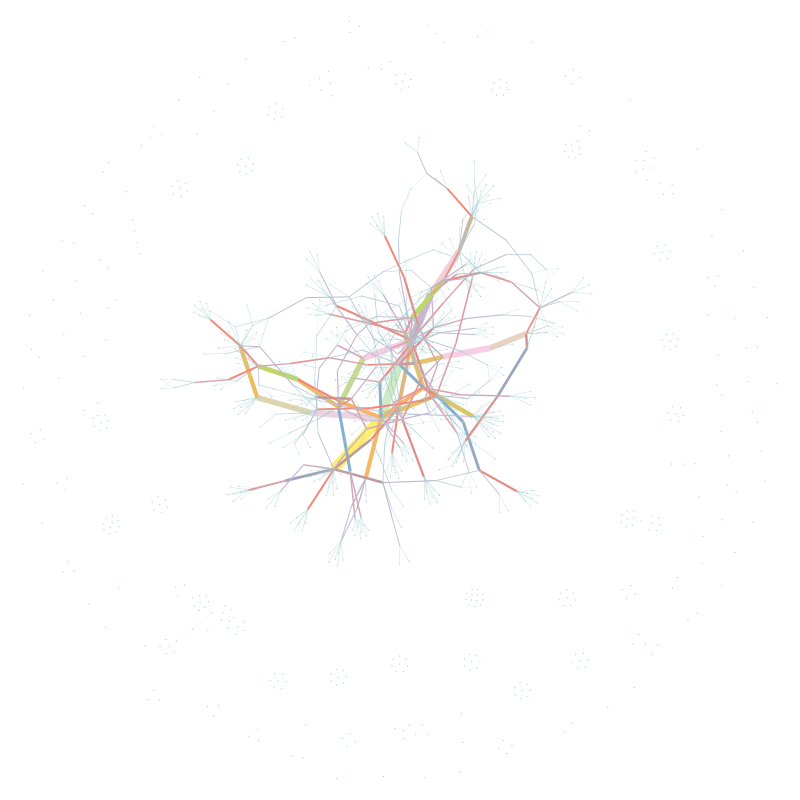

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fda4e3cd7d0, at 0x7fda4c216850>

In [94]:
#g = gt.price_network(1500)
deg = gtG.degree_property_map("in")
deg.a = 4 * (sqrt(deg.a) * 0.5 + 0.4)
ebet = gt.betweenness(gtG)[1]
ebet.a /= ebet.a.max() / 10.
eorder = ebet.copy()
eorder.a *= -1
pos = gt.sfdp_layout(gtG)
control = gtG.new_edge_property("vector<double>")
for e in gtG.edges():
    d = sqrt(sum((pos[e.source()].a - pos[e.target()].a) ** 2)) / 5
    control[e] = [0.3, d, 0.7, d]
gt.graph_draw(gtG, pos=pos,output_size=(800,800), vertex_size=deg, vertex_fill_color=deg, vorder=deg,
              edge_color=ebet, eorder=eorder, edge_pen_width=ebet,
              edge_control_points=control, # some curvy edges
              output="1_SOCIAL_graph-draw.pdf")

In [46]:
# AWESOME !
#g = gt.collection.data["netscience"]
#g = gt.GraphView(g, vfilt=gt.label_largest_component(g))
#g.purge_vertices()
#state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True)
#t = gt.get_hierarchy_tree(state)[0]
#tpos = pos = gt.radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
#cts = gt.get_hierarchy_control_points(g, t, tpos)
#pos = g.own_property(tpos)
#b = state.levels[0].b
#shape = b.copy()
#shape.a %= 14
#gt.graph_draw(g, pos=pos, vertex_fill_color=b, vertex_shape=shape, edge_control_points=cts, edge_color=[0, 0, 0, 0.3], vertex_anchor=0, output="netscience_nested_mdl.pdf")

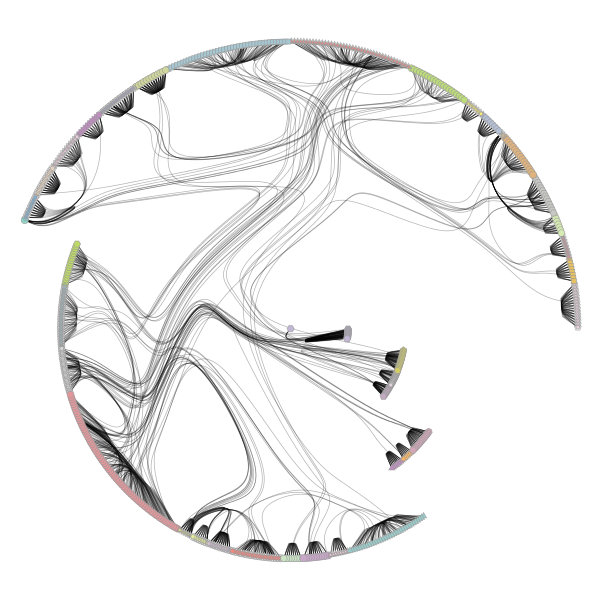

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f90037bdf90, at 0x7f90036e7850>

In [12]:
#g = gt.collection.data["netscience"]
gtG = gt.GraphView(gtG, vfilt=gt.label_largest_component(gtG))
g.purge_vertices()
state = gt.minimize_nested_blockmodel_dl(gtG, deg_corr=True)
t = gt.get_hierarchy_tree(state)[0]
tpos = pos = gt.radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
cts = gt.get_hierarchy_control_points(gtG, t, tpos)
pos = g.own_property(tpos)
b = state.levels[0].b
shape = b.copy()
shape.a %= 14
gt.graph_draw(gtG, pos=pos, vertex_fill_color=b, vertex_shape=shape, edge_control_points=cts, edge_color=[0, 0, 0, 0.3], vertex_anchor=0, output="NYC_SOCIALITE_GRAPH_nested_mdl.pdf")
##g = gt.collection.data["polblogs"]
##pos = gt.arf_layout(gtG)
#gtG = gt.GraphView(gtG, vfilt=gt.label_largest_component(gtG))
#c = gt.closeness(gtG)
#gt.graph_draw(gtG, vertex_fill_color=c,
#               vertex_size=gt.prop_to_size(c, mi=5, ma=15),
#               vcmap=matplotlib.cm.gist_heat,
#               vorder=c, output="MY_TEST_polblogs_closeness.pdf")